In [1]:
import torch
from torch.autograd import Variable
import numpy as np
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from scipy.stats import norm
import itertools
from utils import load_jester
from utils import NormLogCDF

# import jtplot
from jupyterthemes import jtplot

# you can select an alternative theme's plot style by name
# oceans16 | grade3 | chesterish | onedork | monokai | solarizedl
jtplot.style('onedork')

# set "context" (paper, notebook, talk, or poster)
# & font scale (scalar applied to labels, legend, etc.)
jtplot.style('grade3', context='paper', fscale=1.4)

# turn on X- and Y-axis tick marks (default=False)
# and turn off the axis grid lines (default=True)
jtplot.style(ticks=True, grid=False)

# set the default figure size
# x (length), y (height)
jtplot.figsize(x=6., y=5.)

# or just adjust the aspect ratio
# new_length = length * aspect
jtplot.figsize(aspect=1.2)

### Problem 1

In [233]:
w = Variable(torch.from_numpy(np.array([2, -2, -2, -8, -2, 3, -2, 1]).reshape(8, -1)).double(), requires_grad = True)
edges = Variable(torch.from_numpy(np.array([[0, 0, 0, 0, 0, 0, 0, 0], \
                                            [0, 0, 0, 0, 0, 1, 0, 0], \
                                            [0, 0, 0, 0, 0, 1, 0, 0], \
                                            [0, 0, 0, 0, 1, 1, 1, 1], \
                                            [0, 0, 0, 1, 0, 0, 0, 0], \
                                            [0, 1, 1, 1, 0, 0, 0, 0], \
                                            [0, 0, 0, 1, 0, 0, 0, 0], \
                                            [0, 0, 0, 1, 0, 0, 0, 0]])).double())

In [234]:
def global_score(w, edges, seen_ind):
    return torch.exp(torch.mm(torch.transpose(w, 0, 1), seen_ind) + torch.mm(torch.transpose(seen_ind, 0, 1), torch.mm(edges, seen_ind)))

In [235]:
seen_ind = Variable(torch.from_numpy(np.array([1, 0, 0, 0, 0, 1, 0, 0]).reshape(w.size()[0], -1)).double())
global_score(w, edges, seen_ind)

Variable containing:
 148.4132
[torch.DoubleTensor of size 1x1]

In [236]:
def log_partition(w, edges):
    all_possibilities = itertools.product([0, 1], repeat = 8)
    sum_over_scores = Variable(torch.zeros(1).double())
    for i in all_possibilities:
        possibility = Variable(torch.from_numpy(np.array(i).reshape(len(i), -1)).double())
        sum_over_scores = torch.add(sum_over_scores, global_score(w, edges, possibility))
        
    return torch.log(sum_over_scores)

In [237]:
sum_over_universe = log_partition(w, edges)
score = global_score(w, edges, seen_ind)
print(torch.exp(sum_over_universe))
print(score/torch.exp(sum_over_universe))

Variable containing:
 3423.3716
[torch.DoubleTensor of size 1x1]

Variable containing:
1.00000e-02 *
  4.3353
[torch.DoubleTensor of size 1x1]



In [239]:
def get_marginal(marginal, w, edges):
    all_possibilities = itertools.product([0, 1], repeat = 8)
    sum_scores = Variable(torch.zeros(1).double())
    for i in all_possibilities:
        seen_ind = Variable(torch.from_numpy(np.array(i).reshape(len(i), -1)).double())
        if seen_ind[marginal].data.numpy()[0] == 1:
            sum_scores = torch.add(sum_scores, global_score(w, edges, seen_ind))
            
    return sum_scores/torch.exp(sum_over_universe)

get_marginal(5, w, edges)

Variable containing:
 0.9848
[torch.DoubleTensor of size 1x1]

In [240]:
log_part = log_partition(w, edges)
log_part.backward()
w.grad

Variable containing:
 0.8808
 0.4942
 0.4942
 0.0412
 0.1349
 0.9848
 0.1349
 0.7402
[torch.DoubleTensor of size 8x1]

In [241]:
up_exp = np.exp([2, -2, -2, -8, -2, 3, -2, 1])
bp_exp = np.exp(2)
root = 2
edges = [[2, 5], [5, 1, 3], [3, 7, 4, 6]]
leaves = np.array([0, 1, 4, 6, 7])

upwards_bel = np.zeros((len(up_exp), 2))
bel = np.zeros((len(up_exp), 2))
upwards_msg = np.zeros((len(up_exp), 2))
downwards_msg = np.zeros((len(up_exp), 2))

for i in leaves: 
    upwards_bel[i, 0] = 1
    upwards_bel[i, 1] = up_exp[i]

for i in np.flip(edges, axis = 0): 
    parent = i[0]
    child = i[1:]

    for k in child: 
        upwards_msg[k, 0] = np.sum(upwards_bel[k,:])
        upwards_msg[k, 1] = upwards_bel[k, 0] + bp_exp * upwards_bel[k, 1]

    upwards_bel[parent, 0] = np.prod(upwards_msg[child, 0])
    upwards_bel[parent, 1] = up_exp[parent] * np.prod(upwards_msg[child, 1])
    
bel[root, :] = upwards_bel[root, :]
bel[0, :] = upwards_bel[0, :]
        
for i in edges: 
    parent = i[0]
    child = i[1:]
    for k in child: 

        downwards_msg[k, 0] = np.sum(bel[parent, :] / upwards_msg[k, :])
        downwards_msg[k, 1] = bel[parent, 0] / upwards_msg[k, 0] + bp_exp * bel[parent, 1] / upwards_msg[k, 1]

        bel[k, 0] = upwards_bel[k, 0] * downwards_msg[k, 0]
        bel[k, 1] = upwards_bel[k, 1] * downwards_msg[k, 1]

normalized_bel = np.divide(bel, (bel[:, 0] + bel[:, 1]).reshape(len((bel[:, 0] + bel[:, 1])), -1))
print('Marginals: ' + str(normalized_bel[:, 1]))        

Marginals: [ 0.88079708  0.49420107  0.49420107  0.04124983  0.13491074  0.9847716
  0.13491074  0.74019606]


### Problem 2

### Data Setup

In [2]:
user_joke_rating = []
for line in open('jester_ratings.dat', 'r'):
    user_joke_rating_string = line.rstrip()
    user_joke_rating_floats = np.array(user_joke_rating_string.split(' ')).astype(np.float64)
    user_joke_rating.append(user_joke_rating_floats)
    
user_joke_rating = np.array(user_joke_rating)
highest_user = int(np.max(user_joke_rating[:, 0]))
num_jokes = int(np.max(user_joke_rating[:, 1]))

In [3]:
batch_size = 3000
train_iter, val_iter, test_iter, text_field = load_jester(ratings_path='jester_ratings.dat.gz', jokes_path='jester_items.clean.dat.gz', subsample_rate=1.0, batch_size=batch_size, \
                                                          gpu=False, repeat=False, shuffle=True)

Loading Data, this might take several minutes
0 lines read
100000 lines read
200000 lines read
300000 lines read
400000 lines read
500000 lines read
600000 lines read
700000 lines read
800000 lines read
900000 lines read
1000000 lines read
1100000 lines read
1200000 lines read
1300000 lines read
1400000 lines read
1500000 lines read
1600000 lines read
1700000 lines read
Data Loaded


### Problem 2 Functions

In [4]:
def neg_log_likelihood(sigma2, U, V, users, jokes, ratings):
    constant = Variable((torch.ones(1) * np.log((2*np.pi*sigma2)**0.5)).double())
    multiplier = Variable((torch.ones(1) * (2*sigma2)**(-1.0)).double())
    return constant + multiplier * torch.sum((ratings.double() - torch.mm(U, torch.transpose(V, 0, 1))[users.data, jokes.data])**2)

def neg_log_likelihood_biases(sigma2, U, V, a, b, g, users, jokes, ratings):
    constant = Variable((torch.ones(1) * np.log((2*np.pi*sigma2)**0.5)).double())
    multiplier = Variable((torch.ones(1) * (2*sigma2)**(-1.0)).double())
    return constant + multiplier * torch.sum((ratings.double() - torch.mm(U, torch.transpose(V, 0, 1))[users.data, jokes.data] - a[users.data] - b[jokes.data] - g)**2)

def rmse(U, V, data_iter):
    squared_error = 0.0
    num_ratings = 0
    for batch in data_iter:
        ratings = batch.ratings 
        users = batch.users-1 
        jokes = batch.jokes-1
        
        num_ratings += ratings.size()[0]
        squared_error += torch.sum((ratings.double() - torch.mm(U, torch.transpose(V, 0, 1))[users.data, jokes.data])**2)
        
    return ((squared_error/num_ratings)**0.5).data.numpy()[0]

### Problem 2c

In [231]:
# Toy example to do manual calculation of gradients
A = Variable(torch.from_numpy(np.array([[1, 1], [2, 2], [3, 3]])).double(), requires_grad = True)
B = Variable(torch.from_numpy(np.array([[1, 1], [2, 2]])).double(), requires_grad = True)
person_ids = Variable(torch.from_numpy(np.array([0, 1, 2])).long(), requires_grad = True)
song_ids = Variable(torch.from_numpy(np.array([0, 1, 1])).long(), requires_grad = True)
rate = Variable(torch.from_numpy(np.array([1, 2, 3])).long())
sigma2 = 1.0

neg_log_lik = neg_log_likelihood(sigma2, A, B, person_ids, song_ids, rate)
neg_log_lik.backward()

A_num = A.data.numpy()
B_num = B.data.numpy()
rate_matrix = np.array([[1, 0], [0, 2], [0, 3]])
mult = (-torch.ones(1) * (sigma2)**(-1.0)).numpy()

a1_grad = mult * (rate_matrix[0, 0] - A_num[0].reshape(-1, A_num.shape[1]).dot(B_num[0].reshape(B_num.shape[1], -1))) * B_num[0]
a2_grad = mult * (rate_matrix[1, 1] - A_num[1].reshape(-1, A_num.shape[1]).dot(B_num[1].reshape(B_num.shape[1], -1))) * B_num[1]
a3_grad = mult * (rate_matrix[2, 1] - A_num[2].reshape(-1, A_num.shape[1]).dot(B_num[1].reshape(B_num.shape[1], -1))) * B_num[1]
A_grad = np.concatenate([a1_grad, a2_grad, a3_grad], axis = 0)

b1_grad = mult * (rate_matrix[0, 0] - A_num[0].reshape(-1, A_num.shape[1]).dot(B_num[0].reshape(B_num.shape[1], -1))) * A_num[0]
b2_grad = mult * ((rate_matrix[1, 1] - A_num[1].reshape(-1, A_num.shape[1]).dot(B_num[1].reshape(B_num.shape[1], -1))) * A_num[1] +\
                   (rate_matrix[2, 1] - A_num[2].reshape(-1, A_num.shape[1]).dot(B_num[1].reshape(B_num.shape[1], -1))) * A_num[2])
B_grad = np.concatenate([b1_grad, b2_grad], axis = 0)

print('Manual gradient with respect to A:\n' + str(A_grad))
print()
print('Autograd gradient with respect to A:\n' + str(A.grad))
print()
print('Manual gradient with respect to B:\n' + str(B_grad))
print()
print('Autograd gradient with respect to B:\n' + str(B.grad))

Manual gradient with respect to A:
[[  1.   1.]
 [ 12.  12.]
 [ 18.  18.]]

Autograd gradient with respect to A:
Variable containing:
  1   1
 12  12
 18  18
[torch.DoubleTensor of size 3x2]


Manual gradient with respect to B:
[[  1.   1.]
 [ 39.  39.]]

Autograd gradient with respect to B:
Variable containing:
  1   1
 39  39
[torch.DoubleTensor of size 2x2]



### Problem 2d

In [210]:
# batch size 3000
K = 9
sigma2 = 1.0
num_epochs = 5
#U = Variable(torch.from_numpy(np.random.rand(highest_user, K).reshape(highest_user, K)), requires_grad = True)
#V = Variable(torch.from_numpy(np.random.rand(num_jokes, K).reshape(num_jokes, K)), requires_grad = True)
#optimizer = torch.optim.SGD([U, V], lr = 0.0004)

for epoch in range(num_epochs):
    print('Epoch ' + str(epoch))
    batch_num = 0
    for batch in train_iter:
        batch_num += 1
        if batch_num % 100 == 0:
            print('Batch number ' + str(batch_num))

        ratings = batch.ratings
        users = batch.users-1 
        jokes = batch.jokes-1

        optimizer.zero_grad()
        loss = neg_log_likelihood(sigma2, U, V, users, jokes, ratings)
        loss.backward()
        #print(loss.data[0])
        optimizer.step()
        

train_rmse_k = rmse(U, V, train_iter)
val_rmse_k = rmse(U, V, val_iter)

sigma2_mle = train_rmse_k**2

print('Sigma squared MLE = ' + str(sigma2_mle))
print('Train RMSE: ' + str(train_rmse_k))
print('Val RMSE: ' + str(val_rmse_k))

Epoch 0
Batch number 100
Batch number 200
Batch number 300
Batch number 400
Batch number 500
Epoch 1
Batch number 100
Batch number 200
Batch number 300
Batch number 400
Batch number 500
Epoch 2
Batch number 100
Batch number 200
Batch number 300
Batch number 400
Batch number 500
Epoch 3
Batch number 100
Batch number 200
Batch number 300
Batch number 400
Batch number 500
Epoch 4
Batch number 100
Batch number 200
Batch number 300
Batch number 400
Batch number 500
Sigma squared MLE = 1.04658868677
Train RMSE: 1.023029172
Val RMSE: 1.03897252666


### Problem 2e

In [ ]:
sigma2 = 1.0
K = np.arange(10)
optimizer = torch.optim.SGD([U, V], lr = 0.0005)
num_epochs = 10
train_rmse = []
val_rmse = []

for k in K:
    print('K = ' + str(k+1))
    U = Variable(torch.from_numpy(np.random.rand(highest_user, k+1).reshape(highest_user, k+1)), requires_grad = True)
    V = Variable(torch.from_numpy(np.random.rand(num_jokes, k+1).reshape(num_jokes, k+1)), requires_grad = True)
    
    for epoch in range(num_epochs):
        print('Epoch ' + str(epoch))
        batch_num = 0
        for batch in train_iter:
            batch_num += 1
            if batch_num % 100 == 0:
                print('Batch number ' + str(batch_num))

            ratings = batch.ratings 
            users = batch.users-1 
            jokes = batch.jokes-1

            optimizer.zero_grad()
            loss = neg_log_likelihood(sigma2, U, V, users, jokes, ratings)
            loss.backward()
            print(loss.data[0])
            optimizer.step()
            
    train_rmse_k = rmse(U, V, train_iter)
    val_rmse_k = rmse(U, V, val_iter)
    
    print('Train RMSE: ' + str(train_rmse_k))
    print('Val RMSE: ' + str(val_rmse_k))
    
    train_rmse.append(train_rmse_k)
    val_rmse.append(val_rmse_k)

In [225]:
[1.1039178662337159, 1.1282048470046748] #lr = 0.0008, batch_size=3000, k=1
[1.0573551910309043, 1.0920181002235005] #lr = 0.0008, batch_size=3000, k=2
[1.04716172563, 1.06281632165] #lr = 0.0008, batch_size=3000, k=3
[1.04378780926, 1.05934880586] #lr = 0.0005, batch_size=3000, k=4
[1.04299195183, 1.05527209921] #lr = 0.0005, batch_size=3000, k=5
[1.03386666602, 1.04849306749] #lr = 0.0005, batch_size=3000, k=6
[1.03170220691, 1.04641087284] #lr = 0.0005, batch_size=3000, k=7
[1.02506414753, 1.04296469044] #lr = 0.0005, batch_size=3000, k=8
[1.023029172, 1.03897252666] #lr = 0.0004, batch_size=3000, k=9
[1.021032441, 1.03527865811] #lr = 0.0004, batch_size=3000, k=10

K = np.arange(1, 11)
train_rmse = [1.1039178662337159, 1.0573551910309043, 1.04716172563, 1.04378780926, 1.04299195183, 1.03386666602, 1.03170220691, 1.02506414753, 1.023029172, 1.021032441]
val_rmse = [1.1282048470046748, 1.0920181002235005, 1.06281632165, 1.05934880586, 1.05527209921, 1.04849306749, 1.04641087284, 1.04296469044, 1.03897252666, 1.03527865811]

C:\Users\Christopher\Anaconda3\envs\py35\lib\site-packages\matplotlib\figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


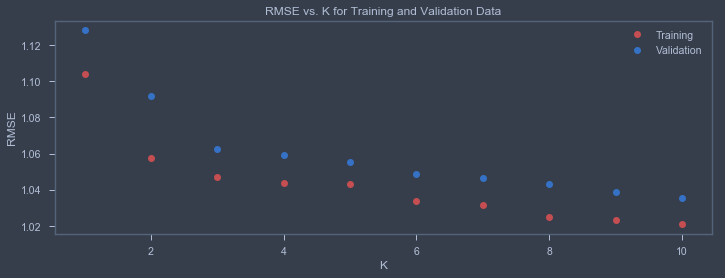

In [227]:
plt.plot(K, train_rmse, 'ro')
plt.plot(K, val_rmse, 'bo')
plt.xlabel('K')
plt.ylabel('RMSE')
plt.title('RMSE vs. K for Training and Validation Data')
plt.legend(labels = ['Training', 'Validation'])
plt.show()

### Problem 2f

In [232]:
# batch size 1000
K = 2
sigma2 = 1.0
num_epochs = 7
U = Variable(torch.from_numpy(0.1 * np.random.randn(highest_user, K).reshape(highest_user, K)), requires_grad = True)
V = Variable(torch.from_numpy(0.1 * np.random.randn(num_jokes, K).reshape(num_jokes, K)), requires_grad = True)
a = Variable(torch.from_numpy(0.1 * np.random.randn(highest_user).reshape(highest_user, -1)), requires_grad = True)
b = Variable(torch.from_numpy(0.1 * np.random.randn(num_jokes).reshape(num_jokes, -1)), requires_grad = True)
g = Variable(torch.ones(1).double() * 3, requires_grad = True)
optimizer = torch.optim.Adam([U, V, a, b, g], lr = 0.05)

for epoch in range(num_epochs):
    print('Epoch ' + str(epoch))
    batch_num = 0
    for batch in train_iter:
        batch_num += 1
        if batch_num % 100 == 0:
            print('Batch number ' + str(batch_num))

        ratings = batch.ratings 
        users = batch.users-1 
        jokes = batch.jokes-1

        optimizer.zero_grad()
        loss = neg_log_likelihood_biases(sigma2, U, V, a, b, g, users, jokes, ratings)
        loss.backward()
        optimizer.step()
        
print('Global bias: ' + str(g.data.numpy()[0]))

Epoch 0
Batch number 100
Batch number 200
Batch number 300
Batch number 400
Batch number 500
Epoch 1
Batch number 100
Batch number 200
Batch number 300
Batch number 400
Batch number 500
Epoch 2
Batch number 100
Batch number 200
Batch number 300
Batch number 400
Batch number 500
Epoch 3
Batch number 100
Batch number 200
Batch number 300
Batch number 400
Batch number 500
Epoch 4
Batch number 100
Batch number 200
Batch number 300
Batch number 400
Batch number 500
Epoch 5
Batch number 100
Batch number 200
Batch number 300
Batch number 400
Batch number 500
Epoch 6


KeyboardInterrupt: 

In [ ]:
# Rank jokes and get biases
jokeID_bias = np.concatenate([np.arange(1, num_jokes+1).reshape(num_jokes, -1), b.data.numpy()], axis = 1)
jokeID_bias[jokeID_bias[:, 1].argsort()]

### Problem 3

In [28]:
jokes_raw = []
for line in open('jester_items.clean.dat', 'r'):
    if len(line) > 5:
        jokes_raw.append(line.rstrip())

In [252]:
raw_transform = CountVectorizer(input='content', encoding='utf-8', decode_error='strict', strip_accents=None, \
                                                                     lowercase=True, preprocessor=None, tokenizer=None, stop_words=None, \
                                                                     ngram_range=(1, 1), analyzer='word', max_df=1.0, min_df=0.045, max_features=None, \
                                                                     vocabulary=None, binary=False)

joke_feature_vectors = raw_transform.fit_transform(jokes_raw).todense()
joke_feature_vectors = np.concatenate([np.ones(num_jokes).reshape(num_jokes, -1), joke_feature_vectors], axis = 1)
joke_feature_vectors.shape

(150, 163)

### Problem 3 Functions

In [261]:
def neg_log_posterior(w, x, sigma, b, y, jokes):
    features = x[jokes.data.numpy()]
    linear = features.dot(w.data.numpy().reshape(w.size()[0], -1))
    
    lower_cut = b[y.data.numpy() - 1].reshape(y.size()[0], -1)
    upper_cut = lower_cut + 2
    np.place(upper_cut, upper_cut == 6, 10.0)
    np.place(lower_cut, lower_cut == -4, -10.0)
    
    lower_cdf_input = (lower_cut - linear)/sigma.data.numpy()
    upper_cdf_input = (upper_cut - linear)/sigma.data.numpy()
    
    lower_cdf = norm.cdf(lower_cdf_input, loc=0, scale=1)
    upper_cdf = norm.cdf(upper_cdf_input, loc=0, scale=1)

    max1 = np.log(1 - np.exp(np.log(lower_cdf) - np.log(upper_cdf))) + np.log(upper_cdf)
    max2 = np.log(1 - np.exp(np.log(1 - upper_cdf) - np.log(1 - lower_cdf))) + np.log(1 - lower_cdf)
    max_matrix = np.concatenate([max1, max2], axis = 1)
    max_log = Variable(torch.from_numpy(np.amax(max_matrix, axis = 1)).double())

    return torch.sum(w**2) - torch.sum(max_log)



def neg_log_gauss_likelihood(w, x, y, sigma):
    return 0.5 * y.size()[0] * torch.log(2.0 * np.pi * (sigma**2)) + 0.5 * sigma**(-2) * torch.sum((y.double() - torch.mm(Variable(torch.from_numpy(np.array(x)).double()), w))**2)



def rmse2(w, x, sigma, b, data_iter):
    Xw = x.dot(w.data.numpy().reshape(w.size()[0], -1))
    
    cdf = np.ones((x.shape[0], len(b) + 1))
    for i in range(cdf.shape[1]):
        if i == 0:
            cdf[:, i] = norm.cdf((cdf[:, i].reshape(cdf.shape[0], -1) * -10.0 - Xw)/sigma.data.numpy()).reshape(cdf.shape[0], )
        elif i == (cdf.shape[1] - 1):
            cdf[:, i] = norm.cdf((cdf[:, i].reshape(cdf.shape[0], -1) * 10.0 - Xw)/sigma.data.numpy()).reshape(cdf.shape[0], )
        else:
            cdf[:, i] = norm.cdf((cdf[:, i].reshape(cdf.shape[0], -1) * b[i] - Xw)/sigma.data.numpy()).reshape(cdf.shape[0], )
            
    prob_matrix = np.zeros((x.shape[0], len(b)))
    for i in range(prob_matrix.shape[1]):
        prob_matrix[:, i] = cdf[:, i+1] - cdf[:, i]
        
    possible_ratings = (np.arange(5) + 1).reshape(5, -1)
    
    expectation_by_joke = prob_matrix.dot(possible_ratings)
    
    squared_error = 0.0
    num_ratings = 0
    for batch in data_iter:
        ratings = batch.ratings-1
        users = batch.users-1 
        jokes = batch.jokes-1
            
        
        num_ratings += ratings.data.numpy().shape[0]
        squared_error += np.sum((expectation_by_joke[jokes.data.numpy()] - ratings.data.numpy().reshape(ratings.size()[0], -1))**2)
        
    return (squared_error/num_ratings)**0.5

### Problem 3.4

In [273]:
num_epochs = 1
b = np.array([-4, -2, 0, 2, 4])
#w = Variable(torch.from_numpy(0.1 * np.random.randn(joke_feature_vectors.shape[1]).reshape(joke_feature_vectors.shape[1], -1)), requires_grad = True)
#sigma = Variable(5 * torch.from_numpy(np.random.rand(1)), requires_grad = True)
#optimizer = torch.optim.Adam([w, sigma], lr = 0.005)

for epoch in range(num_epochs):
    print('Epoch ' + str(epoch))
    batch_num = 0
    for batch in train_iter:
        batch_num += 1
        if batch_num % 100 == 0:
            print('Batch number ' + str(batch_num))

        ratings = batch.ratings-1 
        users = batch.users-1 
        jokes = batch.jokes-1

        optimizer.zero_grad()
        loss = neg_log_posterior(w, joke_feature_vectors, sigma, b, ratings, jokes)
        loss.backward()
        #print(loss.data[0])
        optimizer.step()

print('Test RMSE: ' + str(rmse2(w, joke_feature_vectors, sigma, b, test_iter)))

Epoch 0
Batch number 100
Batch number 200
Batch number 300
Batch number 400
Batch number 500
Test RMSE: 1.30168070677


In [274]:
sigma**2

Variable containing:
 6.5794
[torch.DoubleTensor of size 1]

In [127]:
w

Variable containing:
 2.1116e-28
-1.0308e-16
-1.4834e-29
 2.1508e-28
-1.3963e-30
-5.6252e-23
-2.8840e-15
-5.4405e-28
 2.6699e-28
-6.0757e-29
 9.5374e-25
 4.2562e-25
 3.2805e-27
-1.1288e-28
-1.0367e-28
 5.3538e-27
 7.5423e-28
 6.8906e-27
 2.4212e-28
 1.6025e-27
 1.9136e-27
 6.9395e-11
-5.3347e-23
 1.2013e-27
 8.2377e-30
-4.0415e-27
-1.2174e-27
 9.4410e-28
-3.0547e-30
-1.5727e-27
 8.3317e-08
-2.2609e-28
 8.8179e-26
 5.0226e-29
 1.1196e-27
-1.3341e-28
-1.5650e-28
-4.4472e-23
-4.3138e-09
 1.1640e-26
-7.3984e-29
 7.1223e-27
-2.7051e-27
-8.1352e-26
-8.1057e-27
 4.8437e-28
-6.2097e-29
-1.0371e-10
 6.1987e-28
-3.4184e-18
-1.1628e-27
 1.4036e-28
 1.1711e-27
-1.7286e-07
-1.8521e-29
 2.9590e-28
 3.5942e-15
-2.8348e-19
-3.3798e-29
 1.6894e-18
 9.8680e-21
-7.4688e-31
-5.3513e-28
-7.4957e-28
 1.9887e-29
-1.8535e-23
-2.4486e-24
-2.8668e-28
 1.8600e-23
-5.2279e-21
 2.2171e-24
-2.0490e-29
-1.0312e-24
 1.3340e-28
-1.0207e-21
 2.7474e-27
 2.8038e-27
 2.7497e-09
-1.6223e-26
 3.5194e-28
-8.9755e-17
 3.5600

### Problem 3.5

In [194]:
num_epochs = 5
b = np.array([-4, -2, 0, 2, 4])
w = Variable(torch.from_numpy(0.1 * np.random.randn(joke_feature_vectors.shape[1]).reshape(joke_feature_vectors.shape[1], -1)), requires_grad = True)
sigma = Variable(torch.from_numpy(np.array(np.random.rand(1))), requires_grad = True)
optimizer = torch.optim.Adam([w, sigma], lr = 0.05)

for epoch in range(num_epochs):
    print('Epoch ' + str(epoch))
    batch_num = 0
    for batch in train_iter:
        batch_num += 1
        if batch_num % 100 == 0:
            print('Batch number ' + str(batch_num))

        ratings = batch.ratings-1 
        users = batch.users-1
        jokes = batch.jokes-1

        optimizer.zero_grad()
        loss = neg_log_gauss_likelihood(w, joke_feature_vectors, ratings, sigma)
        loss.backward()
        #print(loss.data[0])
        optimizer.step()

print('Test RMSE: ' + str(rmse2(w, joke_feature_vectors, sigma, b, test_iter)))

Epoch 0
Batch number 100
Batch number 200
Batch number 300
Batch number 400
Batch number 500
Test RMSE: 1.31696375464
